# K-means clustering

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from numba import jit
from PIL import Image
from sklearn.cluster import KMeans

%matplotlib inline

In [100]:
data = loadmat('data/ex7data2.mat')
X = data['X']
X.shape

(300, 2)

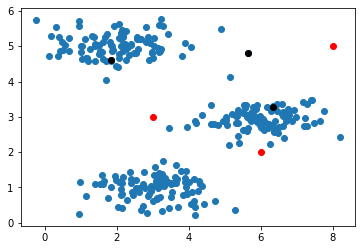

In [75]:
plt.scatter(X[:,0], X[:,1])
test = np.array([[3,3], [6,2],[8,5]])
plt.scatter(test[:,0], test[:,1], c='r')
plt.scatter(X[:3,0],X[:3,1], c='k')
plt.show()

## Initialization

In [194]:
def initialize_centroids(X, k):
    return X[np.random.choice(X.shape[0], k), :] 

In [215]:
init = initialize_centroids(X, 3)

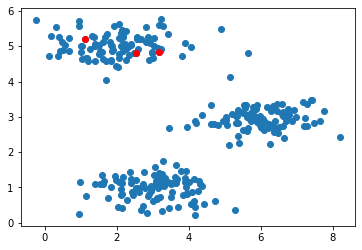

In [216]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(init[:,0], init[:,1], c='r')
plt.show()

## Get nearest centroids

In [109]:
# @jit(nopython=True)
def find_nearest_centorids(X, centroids):
    return np.array([np.argmin(np.linalg.norm(X[i,:] - centroids, axis=1)) for i in range(X.shape[0])])

In [110]:
%%time
idx = find_nearest_centorids(X, test)
idx[:3]

Wall time: 10 ms


array([0, 2, 1], dtype=int64)

## Update centroids

In [150]:
def update_centroids(X, idx):
    k = len(np.unique(idx))
    centroids = np.zeros((k, X.shape[1]))
    
    for i in range(k):
        clustering_index = np.where(idx == i)
        centroids[i,:] = np.mean(X[clustering_index], axis=0)
    return centroids

In [151]:
update_centroids(X, idx)

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

## Iteration

In [223]:
def run(X, initial_centroids, max_iters):
    m, n = X.shape
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        idx = find_nearest_centorids(X, centroids)
        centroids = update_centroids(X, idx)
        
    return idx, centroids

In [224]:
%%time
idx, centroids = run(X, init, 20)

cluster0 = X[np.where(idx==0)]
cluster1 = X[np.where(idx==1)]
cluster2 = X[np.where(idx==2)]

cluster0.shape, cluster1.shape, cluster2.shape

Wall time: 163 ms


((100, 2), (98, 2), (102, 2))

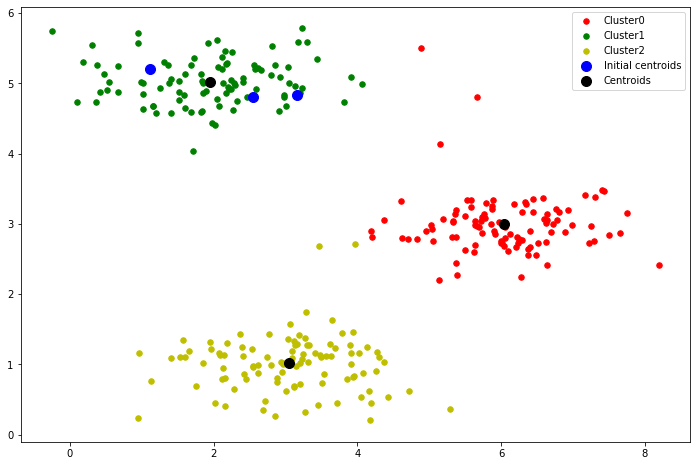

In [225]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(cluster0[:,0], cluster0[:,1], s=30, c='r', label='Cluster0')
ax.scatter(cluster1[:,0], cluster1[:,1], s=30, c='g', label='Cluster1')
ax.scatter(cluster2[:,0], cluster2[:,1], s=30, c='y', label='Cluster2')
ax.scatter(init[:,0], init[:,1], s=100, c='b', label='Initial centroids')
ax.scatter(centroids[:,0], centroids[:,1], s=100, c='k', label='Centroids')
ax.legend()
plt.show()

## Encapsulation

In [326]:
class KMeans_:
    def __init__(self, X, k_clusters):
        self.X = X
        self.k = k_clusters
        self.init = None
        self.idx = None
        self.centroids = None
    
    def initialize_centroids(self):
        self.init = self.X[np.random.choice(self.X.shape[0], self.k), :]
        return self.init
    
    def update_idx(self):
        if self.centroids is None:
            self.centroids = self.init
        self.idx = np.array([np.argmin(np.linalg.norm(self.X[i,:] - self.centroids, axis=1)) 
                             for i in range(self.X.shape[0])])
        return self.idx
    
    def update_centroids(self):
        for i in range(self.k):
            clustering_index = np.where(self.idx == i)
            self.centroids[i,:] = np.mean(self.X[clustering_index], axis=0)
    
    def fit(self, max_iters=20):
        self.centroids = self.initialize_centroids()
        self.idx = self.update_idx()
        for i in range(max_iters):
            self.update_centroids()
            self.update_idx()

    def cluster_centers_(self):
        return self.centroids
    
    def predict(self):
        return self.idx

In [327]:
km = KMeans_(X, 3)

km.fit()
init = km.initialize_centroids()
centroids_ = km.cluster_centers_()

cluster0 = X[np.where(km.predict()==0)]
cluster1 = X[np.where(km.predict()==1)]
cluster2 = X[np.where(km.predict()==2)]

cluster0.shape, cluster1.shape, cluster2.shape,init.shape

((100, 2), (102, 2), (98, 2), (3, 2))

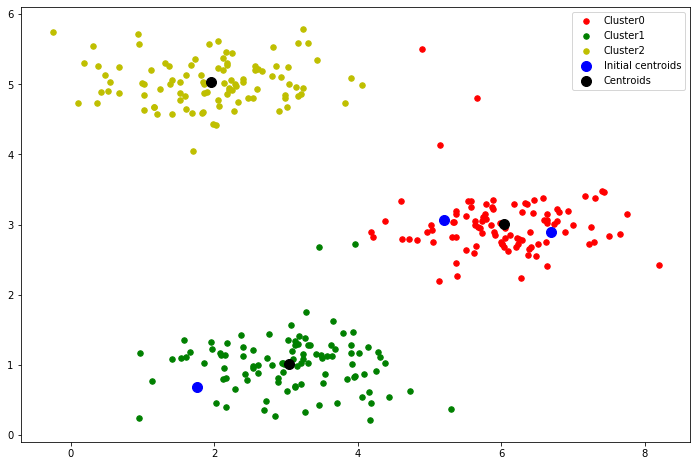

In [328]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(cluster0[:,0], cluster0[:,1], s=30, c='r', label='Cluster0')
ax.scatter(cluster1[:,0], cluster1[:,1], s=30, c='g', label='Cluster1')
ax.scatter(cluster2[:,0], cluster2[:,1], s=30, c='y', label='Cluster2')
ax.scatter(init[:,0], init[:,1], s=100, c='b', label='Initial centroids')
ax.scatter(centroids_[:,0], centroids_[:,1], s=100, c='k', label='Centroids')
ax.legend()
plt.show()

# Compress image

## Manually

In [256]:
image_data_origin = np.array(Image.open('data/bird_small.png'))
image_data_origin.shape

(128, 128, 3)

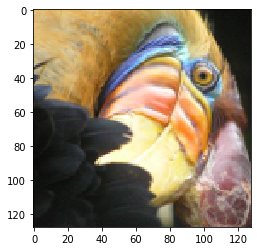

In [258]:
plt.imshow(image_data_origin)
plt.show()

In [252]:
image_data = image_data_origin / 255.
image_data = image_data.reshape(-1, 3)
image_data.shape

(16384, 3)

In [ ]:
initial_centroids = initialize_centroids(image_data, 16)
idx, centroids = run(image_data, initial_centroids, 10)

In [240]:
centroids.shape,idx.shape

((16, 3), (16384,))

In [253]:
image_recovered = centroids[idx].reshape(image_data_origin.shape)
image_recovered.shape

(128, 128, 3)

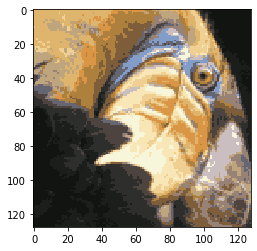

In [255]:
plt.imshow(image_recovered)
plt.show()

## Build-in method

In [260]:
model = KMeans(n_clusters=16, n_init=100)
model.fit(image_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [261]:
centorids = model.cluster_centers_
C = model.predict(image_data)
centorids, C

(array([[0.08481743, 0.09187427, 0.08166229],
        [0.76003787, 0.61019171, 0.34521456],
        [0.9769406 , 0.9462354 , 0.81800764],
        [0.28934012, 0.25832202, 0.25363499],
        [0.91946089, 0.57270017, 0.25407902],
        [0.16465832, 0.16619936, 0.15817311],
        [0.65626618, 0.47663289, 0.214537  ],
        [0.70025637, 0.62900821, 0.5627356 ],
        [0.56956863, 0.72134902, 0.86848627],
        [0.58652913, 0.49902287, 0.44719375],
        [0.82790622, 0.74642474, 0.73704679],
        [0.47031304, 0.34001835, 0.18055269],
        [0.38738152, 0.45808552, 0.6478113 ],
        [0.86981474, 0.71864391, 0.45752574],
        [0.45454722, 0.38490658, 0.35412202],
        [0.96401754, 0.85984621, 0.63239916]]),
 array([13, 13, 13, ...,  5,  5,  5]))

In [262]:
compressed_pic = centorids[C].reshape(image_data_origin.shape)

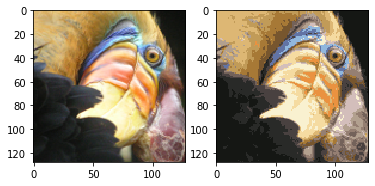

In [264]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image_data_origin)
ax[1].imshow(compressed_pic)
plt.show()

# PCA
[算法视频回顾 -- Andrew Ng](https://study.163.com/course/courseLearn.htm?courseId=1004570029#/learn/video?lessonId=1052345566&courseId=1004570029)

在确保数据被归一化之后，输出仅仅是原始数据的协方差矩阵的奇异值分解。

## PCA with data

In [338]:
data = loadmat('data/ex7data1.mat')
X = data['X']
X.shape

(50, 2)

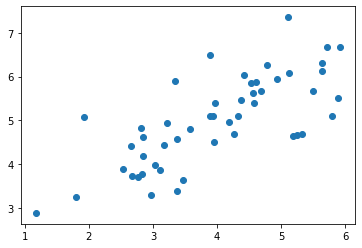

In [330]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [346]:
def pca(X):
    X = (X - X.mean()) / X.std()
    cov = (X.T @ X) / X.shape[0]
    U, S, V = np.linalg.svd(cov)
    return U, S, V

In [347]:
U, S, V = pca(X)
U, S, V

(matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]),
 array([1.43584536, 0.56415464]),
 matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]))

In [348]:
def project_data(X, U, k):
    U_reduced = U[:, :k]
    return np.dot(X, U_reduced)

In [350]:
z = project_data(X, U, 1)

In [351]:
def recover_data(Z, U, k):
    U_reduced = U[:, :k]
    return np.dot(Z, U_reduced.T)

In [356]:
X_recovered = recover_data(z, U, 1)
X_recovered.shape

(50, 2)

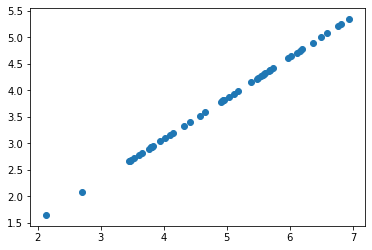

In [363]:
plt.scatter(np.ravel(X_recovered[:, 0]), np.ravel(X_recovered[:, 1]))
plt.show()

## PCA with pics

In [364]:
faces = loadmat('data/ex7faces.mat')
X = faces['X']
X.shape

(5000, 1024)

In [376]:
def plot_n_image(X, n):
    pic_size = int(np.sqrt(X.shape[1]))
    grid_size = int(np.sqrt(n))
    
    first_n_images = X[:n, :]
    
    fig, axes = plt.subplots(grid_size, grid_size, True, True, figsize=(8, 8))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(first_n_images[i].reshape((pic_size, pic_size)).T)
        ax.set_xticks([])
        ax.set_yticks([])

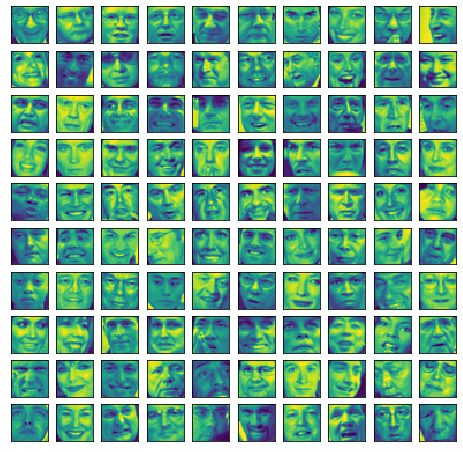

In [378]:
plot_n_image(X, 100)

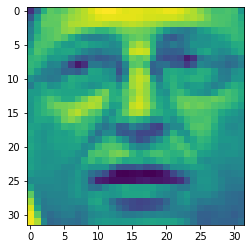

In [382]:
face = np.reshape(X[3], (32, 32)).T
plt.imshow(face)
plt.show()

In [383]:
U, S, V = pca(X)
Z = project_data(X, U, 100)

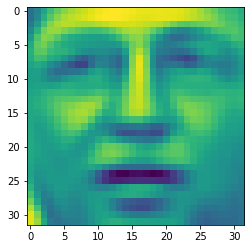

In [384]:
X_recovered = recover_data(Z, U, 100)
face = np.reshape(X_recovered[3], (32,32)).T
plt.imshow(face)
plt.show()